## Loading a sub-01 test run:

In [2]:
import pandas as pd
import nibabel as nib

sleep_score = pd.read_csv('sleep_data/sleep_scores/sub-01-sleep-stage.tsv', sep='\t')
sessions = sleep_score['session'].unique()
data = nib.load(f"sleep_data/sub-{str(0+1).zfill(2)}_{sessions[0]}_bold.nii.gz").get_fdata()
data.shape

(80, 80, 35, 286)

### Defining regions in the data with the Schaefer2018 100Parcels atlas combined with the Tian Subcortex 16Parcels atlas:

In [5]:
import numpy as np

atlas = nib.load('sleep_data\Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1_3T_MNI152NLin2009cAsym_2mm.nii.gz')
atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_labels = np.unique(atlas_data)
atlas_labels = atlas_labels[1:] # remove 0
atlas_labels = atlas_labels.astype(int)

# Dimensions don't work for the atlas and the 80x80x35 nii data?
print(atlas_data.shape, data_region.shape)

data_region = np.zeros((data.shape[3], len(atlas_labels)))
for j in range(len(atlas_labels)):
    for k in range(data.shape[3]):
        data_region[k,j] = np.mean(data[:,:,:,k][atlas_data == atlas_labels[j]])


(97, 115, 97) (286, 116)


IndexError: boolean index did not match indexed array along dimension 0; dimension is 80 but corresponding boolean dimension is 97

......

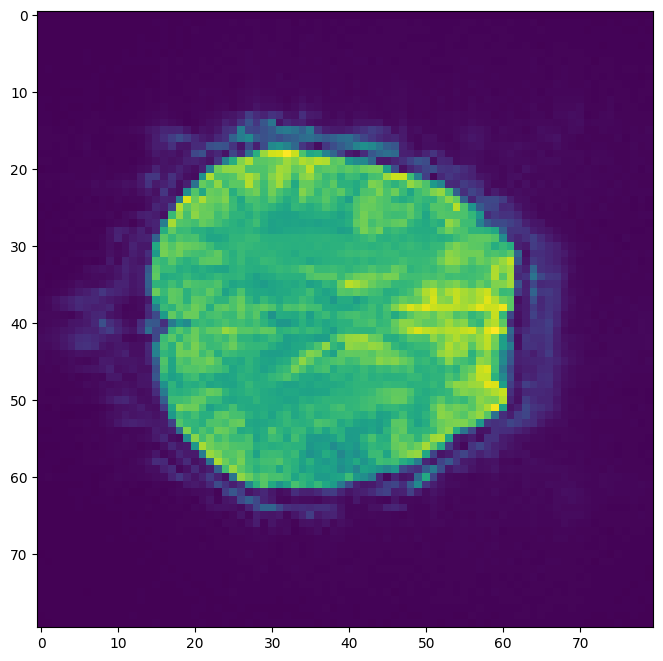

In [23]:
def animate_snapshots(idx, data, fps=30, nSeconds=5):
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation
    
    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure( figsize=(8,8) )
    snapshots = data[:,:,idx,:]
    a = snapshots[..., 0]
    im = plt.imshow(a)

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        im.set_array(snapshots[..., i])
        return [im]

    anim = FuncAnimation(fig, animate_func, frames = nSeconds * fps, interval = 1000 / fps)
    anim.save(f'time-varying-fmri-signal-i_{idx}.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])

animate_snapshots(idx=21, data=data)

In [145]:
from scipy.signal import butter, filtfilt, hilbert
normalized = lambda x: x / np.sum(x)

nyquist = 0.5 * 1/2.1 # code from "proc_data.py"
low = 0.008 / nyquist
high = 0.09 / nyquist
b, a = butter(2, [low, high], btype='band')

data_filtered = np.zeros_like(data)
for j in range(len()):
    data_filtered[:,j] = filtfilt(b, a, data[:,j])

# s_series = normalized(data[40,40,21,:])
# plt.plot(s_series)
# plt.xlabel('Time [s]');

array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-1.14688250e-02, -1.90631065e-01, -1.46120982e-01, ...,
          8.41812539e-01,  6.68113819e-01,  9.02460590e-02],
        [-1.16653257e-02,  3.78001096e-01,  5.70312287e-01, ...,
         -2.93376290e-01, -1.61504939e

In [220]:
def angle(x): return np.arctan(np.imag(x) / np.real(x))

def hilbert(u): # https://stackoverflow.com/questions/56380536/hilbert-transform-in-python
    from scipy.fftpack import fft, ifft
    N = len(u)
    U = fft(u) # forward Fourier transform
    M = N - N//2 - 1
    U[N//2+1:] = [0] * M # zero out negative frequency components
    U[1:N//2] = 2 * U[1:N//2] # double fft energy except @ DC0
    v = ifft(U) # inverse Fourier transform
    return v

angle(hilbert(s_series))

array([ 2.33747579e-02,  4.38846730e-02, -4.01898465e-03,  1.44790825e-03,
        9.55892945e-03,  4.65471712e-03, -1.65190025e-03,  2.15316882e-03,
        5.61842937e-03,  5.73239143e-03, -7.78048102e-03,  3.33527760e-03,
       -1.50955638e-03,  1.20175426e-02, -1.71194436e-03, -1.15208076e-03,
       -8.80099270e-03,  6.61762548e-03,  5.82756626e-03,  1.11472076e-02,
        4.74591355e-03,  8.06280014e-03,  1.69347762e-02,  6.66989246e-04,
       -8.83148601e-03,  1.13242622e-02, -9.61844169e-03, -1.40515336e-02,
        1.04060740e-02,  1.93692307e-02, -4.37748656e-03,  4.43283272e-03,
       -9.41151420e-03,  5.06326446e-03, -7.98193869e-04, -8.34462830e-03,
       -5.19772489e-04, -2.47165996e-04,  1.80732860e-03, -4.13240760e-03,
       -1.04481311e-03,  1.51607259e-02,  4.26983568e-03, -7.73436131e-03,
        9.61005372e-03, -1.44116846e-03,  1.82839081e-03, -2.00198730e-02,
       -4.00159381e-02,  1.02030224e-02,  1.62181969e-02, -6.43659427e-03,
       -8.13890760e-03,  

In [210]:
np.arctan(s_series[0] * 1/(np.pi*1) / s_series[0])

0.30816907111598496

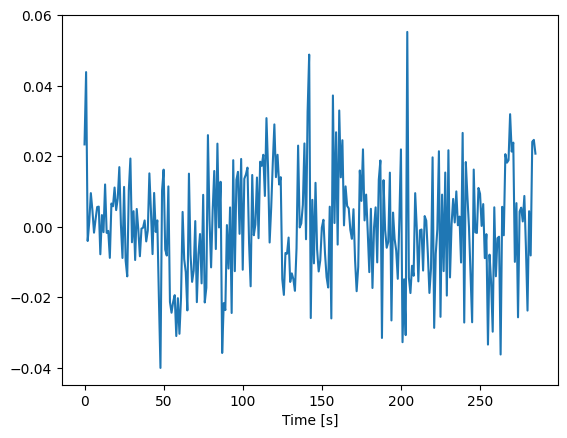

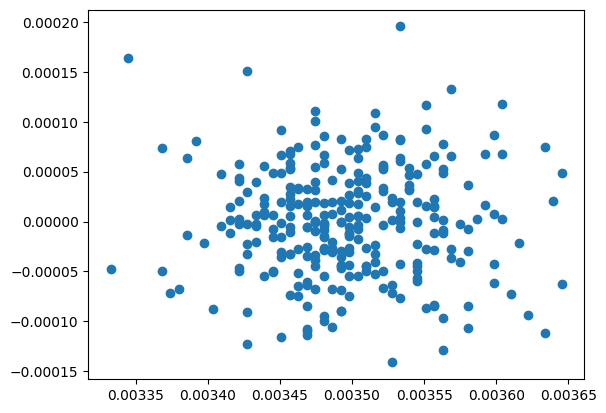

In [74]:
theta_series = np.angle(hilbert(s_series))
plt.plot(theta_series)
plt.xlabel('Time [s]');
plt.show()

hilbert_complex = hilbert(s_series)
plt.scatter(np.real(hilbert_complex), np.imag(hilbert_complex));

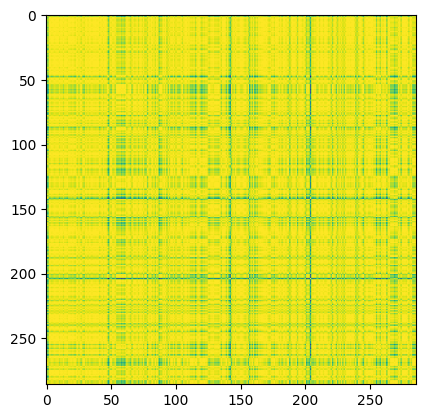

In [79]:
coh_map = lambda x: np.outer(np.cos(x), np.cos(x)) + np.outer(np.sin(x), np.sin(x))
A = coh_map(theta_series)
plt.imshow(A);

Explained Variance
v1: 0.03%	 v2: 99.97%


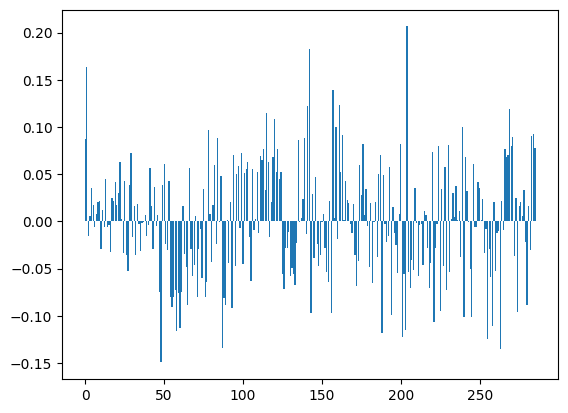

In [141]:
eigval, eigvec = np.linalg.eigh(A)
eigval, eigvec = eigval[-2:], eigvec[:,-2:]
v1, v2 = eigvec[:,0], eigvec[:,1]
plt.bar(range(len(v1)), v1);
# explained variance as percentage:
print(f"Explained Variance\nv1: {normalized(eigval)[0]:.2%}\t v2: {normalized(eigval)[1]:.2%}")

In [ ]:
from riemannian_kmeans import diametrical_clustering
data_sphere = v1
K = 2
C_dm,part,obj = diametrical_clustering(X=data_sphere,K=K,num_repl=1,init=None)

In [1]:
import nibabel as nib

nyquist = 0.5 * 1/2.1
low = 0.008 / nyquist
high = 0.09 / nyquist
b, a = butter(2, [low, high], btype='band')

data = nib.load('9_resting-pre-motor.nii')
data = data.get_fdata()
data_region = data

# Parcellation
"missing"

# Filtering
data_region_filtered = np.zeros_like(data_region)
for j in range(data_region.shape[1]):
    data_region_filtered[:,j] = filtfilt(b, a, data[:,j])

# Hilbert
data_region_phase = np.zeros_like(data_region_filtered)
for j in range(data_region_filtered.shape[1]):
    data_region_phase[:,j] = np.angle(hilbert(data_region_filtered[:,j]))

# Coherence maps
coh_map = lambda x: np.outer(np.cos(x), np.cos(x)) + np.outer(np.sin(x), np.sin(x))
eigval,eigvec = np.linalg.eigh(coh_map(data_region_phase[0]))
# Eigenvectors

MemoryError: Unable to allocate 4.67 TiB for an array with shape (800800, 800800) and data type float64

In [ ]:
import numpy as np

def calc_MI(Z1, Z2):
    P = Z1 @ Z2.T # joint probability matrix
    PXY = P / np.sum(P) # joint probability matrix normalized
    PXPY = np.outer(np.sum(PXY,axis=1),np.sum(PXY,axis=0)) # product of marginals
    ind = np.where(PXY > 0) # non-zero elements
    MI = np.sum(PXY[ind] * np.log(PXY[ind]/PXPY[ind])) # mutual information
    return MI

def calc_NMI(Z1, Z2):
    # Z1 and Z2 are two partition matrices of size (KxN) where K is number of components and N is number of samples
    NMI = calc_MI(Z1,Z2) / np.mean([calc_MI(Z1,Z1), calc_MI(Z2,Z2)])
    return NMI


# random 4x4 matrix
X = np.random.rand(4,4)
calc_MI(X, X)
